<a href="https://colab.research.google.com/github/suryamn1/deep-learning-projects/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense 
from keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
import pandas as pd
import os
from os import listdir
from PIL import Image
from numpy import array
from numpy import asarray
import seaborn as sns

In [ ]:
from google.colab import files
upload=files.upload()

In [5]:
import zipfile,os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
"""
!wget --no-check-certificate \
    "https://github.com/giovannipcarvalho/banana-ripeness-classification/archive/refs/heads/master.zip" \
    -O "/tmp/bananas.zip"
"""
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/banana_ripeness.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp1') #Extracts the files into the /tmp folder
zip_ref.close()
img_height,img_width=200,200
batch_size=32
shape_sum = 0
class_name_numb = dict()
train_avg_shape = 80
training_img_list = list()
images_dir = '/tmp1/Fayoum_University_Banana _Classes'
for dirname, _, filenames in os.walk(images_dir):
    for filename in filenames:
        img_data = Image.open(os.path.join(dirname, filename))
        
        resizedImage = img_data.resize((train_avg_shape, train_avg_shape))
        resizedImage = resizedImage.convert('RGB')
        resizedImage = asarray(resizedImage)/255
        
        class_label = dirname.split('/')[-1]
        training_img_list.append([resizedImage, class_label])
        shape_sum += np.max(img_data.size)
        class_name_numb[class_label] = len(class_name_numb)-1

***Data Preprocessing***

In [6]:
import zipfile,os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
images_dir = '/tmp1/Fayoum_University_Banana _Classes'
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    images_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    images_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') 

from sklearn.model_selection import KFold
from numpy import asarray
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(17)
kf = KFold(n_splits=5)
epochs = 20
batch_size = 32

Found 221 images belonging to 4 classes.
Found 52 images belonging to 4 classes.


**Classification using ResNet50 pretrained model**

In [222]:
from keras.layers import BatchNormalization,Dropout
from tensorflow.keras.applications.resnet50 import ResNet50

resnet_model = Sequential()

pretrained_model= ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dropout(0.3))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(16, activation='softmax'))

resnet_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 32)                65568     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

In [223]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=7)

In [225]:
resnet_model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_generator, epochs=25,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/25
7/7 [==============================] - 45s 6s/step - loss: 1.5759 - accuracy: 0.3529 - val_loss: 1.3805 - val_accuracy: 0.4038
Epoch 2/25
7/7 [==============================] - 40s 6s/step - loss: 1.4460 - accuracy: 0.3348 - val_loss: 1.3246 - val_accuracy: 0.3462
Epoch 3/25
7/7 [==============================] - 41s 6s/step - loss: 1.3146 - accuracy: 0.4389 - val_loss: 1.3712 - val_accuracy: 0.3846
Epoch 4/25
7/7 [==============================] - 41s 6s/step - loss: 1.3464 - accuracy: 0.4480 - val_loss: 1.3137 - val_accuracy: 0.3846
Epoch 5/25
7/7 [==============================] - 41s 6s/step - loss: 1.3618 - accuracy: 0.4208 - val_loss: 1.3588 - val_accuracy: 0.4038
Epoch 6/25
7/7 [==============================] - 41s 6s/step - loss: 1.3009 - accuracy: 0.4163 - val_loss: 1.3511 - val_accuracy: 0.3846
Epoch 7/25
7/7 [==============================] - 41s 6s/step - loss: 1.3389 - accuracy: 0.4570 - val_loss: 1.4808 - val_accuracy: 0.3654
Epoch 8/25
7/7 [==================

**Feature extraction using VGG16 and classification using logistic regression model**

In [146]:

def gen_label(directory):
    label = []
    for subdir, dirs, files in os.walk(directory):
     for file in files:
        f=os.path.join(subdir, file)
        if f.split('/')[3] == 'Green':
            label.append(str(0))
        elif f.split('/')[3] == 'Midripen':
            label.append(str(1))
        elif f.split('/')[3] == 'Overripen':
            label.append(str(2))
        elif f.split('/')[3] == 'Yellowish_Green':
            label.append(str(3))
    return label
    #print(len(label),"files in", directory) 
def get_path(directory):
    path = []
    for subdir, dirs, files in os.walk(directory):
     for file in files:
        path.append(os.path.join(subdir, file))
    return path

train_y = gen_label('/tmp1/Fayoum_University_Banana _Classes')
train_x = get_path('/tmp1/Fayoum_University_Banana _Classes')

In [147]:
df = pd.DataFrame({'filename': train_x,'category':train_y})
df.head()

,filename,category
0,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
1,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
2,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
3,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
4,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3


In [143]:
len(df)

273

In [68]:
from keras.preprocessing import image

VGG16 pretrained model

In [134]:
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layers in vgg.layers:
    layers.trainable=False

print(vgg.output)

58900480/58889256 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [135]:
feature_list = []
for path in df['filename'].to_numpy():
    x = image.load_img(path,target_size=(224,224))
    img_array = image.img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    feature_list.append(features)
    
feat_lst = np.reshape(feature_list,(-1,7*7*512))

In [136]:
feat_lst.shape

(273, 25088)

Logistic regression classifier

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
y = df['category'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=2020)

glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

LogisticRegression(C=0.1)

In [157]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))

Accuracy on validation set using Logistic Regression:  0.9090909090909091


In [148]:
test_df=df.sample(frac=1)

In [150]:
test_df=test_df[1:50]

In [151]:
test_df

,filename,category
144,/tmp1/Fayoum_University_Banana _Classes/Midrip...,1
3,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
97,/tmp1/Fayoum_University_Banana _Classes/Midrip...,1
34,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
24,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3
69,/tmp1/Fayoum_University_Banana _Classes/Overri...,2
185,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
255,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
115,/tmp1/Fayoum_University_Banana _Classes/Midrip...,1
79,/tmp1/Fayoum_University_Banana _Classes/Overri...,2


In [163]:

test_sample = test_df.sample(n=12, random_state=2020)

def test_img(model):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = path
        x = image.load_img(full_path, target_size=(224,224))
        img_array = image.img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        features = model.predict(img_array)
        features = np.reshape(features,(-1,7*7*512))
        result = glm.predict(features)
        if float(result)<0.5 and float(result)>=0:
          result_lst.append('Green')
        elif (float(result)>0.5 and float(result)<=1) or (float(result)<1.5 and float(result)>=1):
          result_lst.append('Midripen')
        elif (float(result)>1.5 and float(result)<=2) or (float(result)<2.5 and float(result)>=2):
          result_lst.append('Overripen')
        elif float(result)>2.5 and float(result)<=3:
          result_lst.append('Yellowish_Green')

    return result_lst

In [164]:
trflearn_result = test_img(vgg)

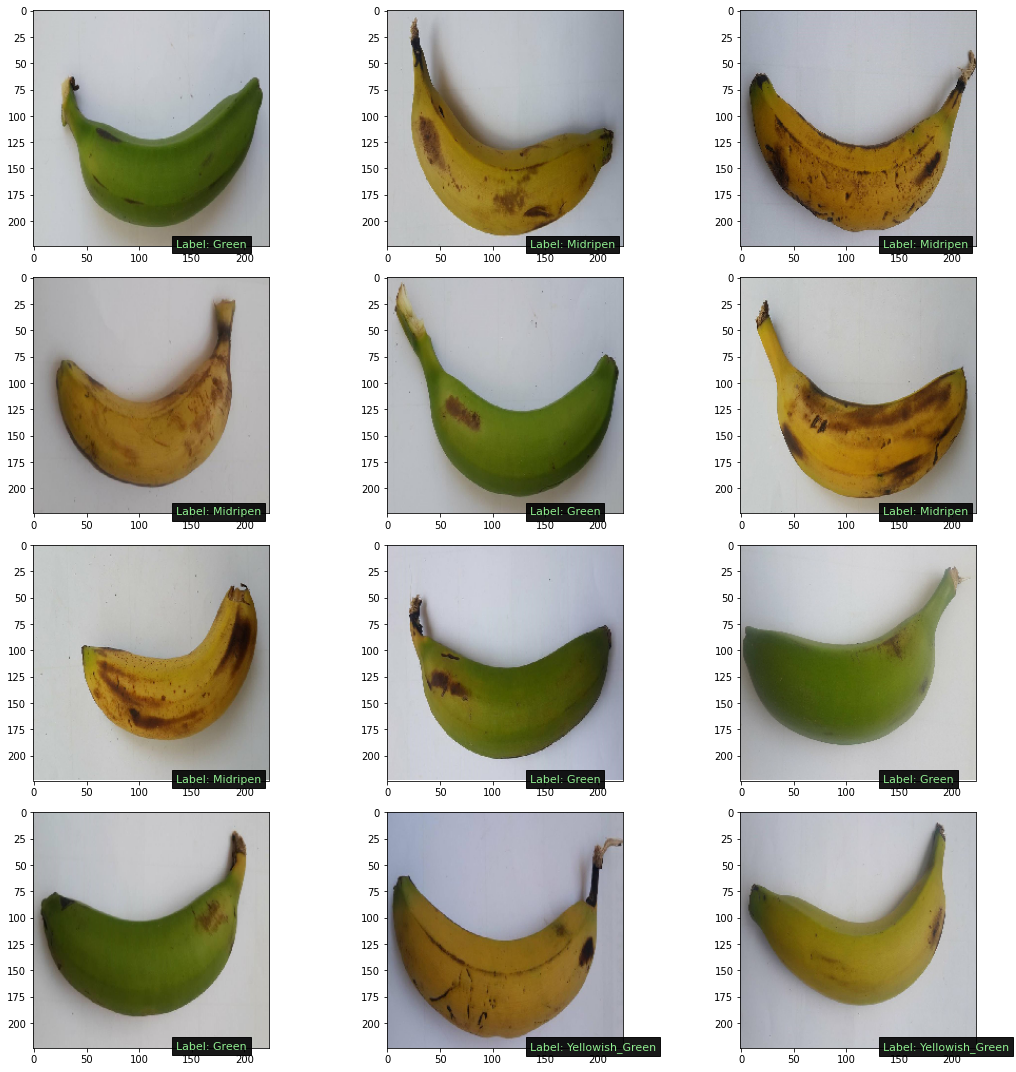

In [174]:
test_array = test_sample['filename'].to_numpy()
from keras.preprocessing import image
plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    tf = trflearn_result[i]
    img = test_array[i]
    path = img
    x = image.load_img(path, target_size=(224,224))
    plt.text(135, 225, 'Label: {}'.format(tf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(x)

plt.tight_layout()
plt.show()